# Trương Hồng Anh
# MSSV :22520084
# Bài thực hành 2

In [ ]:
!pip install imutils
!pip install gdown

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
from imutils import paths
import cv2
import matplotlib.pyplot as plt

In [3]:
data_path = './'

dataset = datasets.Caltech101(
    root=data_path,
    download=True,
)

Downloading...
From (original): https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
From (redirected): https://drive.usercontent.google.com/download?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp&confirm=t&uuid=34053b9e-0f1f-4c8f-8a45-b615d5baf276
To: /kaggle/working/caltech101/101_ObjectCategories.tar.gz
100%|██████████| 132M/132M [00:04<00:00, 32.5MB/s] 


Extracting ./caltech101/101_ObjectCategories.tar.gz to ./caltech101


Downloading...
From (original): https://drive.google.com/uc?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m
From (redirected): https://drive.usercontent.google.com/download?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m&confirm=t&uuid=a878522f-4f4e-4930-818a-ee26223e1df6
To: /kaggle/working/caltech101/Annotations.tar
100%|██████████| 14.0M/14.0M [00:00<00:00, 16.2MB/s]


Extracting ./caltech101/Annotations.tar to ./caltech101


In [4]:
class_name = list(os.listdir("/kaggle/working/caltech101/101_ObjectCategories"))
print(class_name)

['ant', 'windsor_chair', 'stapler', 'barrel', 'laptop', 'lamp', 'ewer', 'cup', 'strawberry', 'binocular', 'butterfly', 'ibis', 'Motorbikes', 'garfield', 'brain', 'nautilus', 'accordion', 'stegosaurus', 'trilobite', 'pyramid', 'pizza', 'BACKGROUND_Google', 'dragonfly', 'rhino', 'Faces_easy', 'flamingo_head', 'electric_guitar', 'Leopards', 'rooster', 'ferry', 'cougar_body', 'llama', 'crab', 'lobster', 'car_side', 'joshua_tree', 'grand_piano', 'starfish', 'emu', 'dolphin', 'sea_horse', 'schooner', 'tick', 'gramophone', 'menorah', 'beaver', 'stop_sign', 'scorpion', 'dollar_bill', 'flamingo', 'brontosaurus', 'wrench', 'pagoda', 'wheelchair', 'lotus', 'minaret', 'platypus', 'gerenuk', 'crocodile_head', 'metronome', 'Faces', 'anchor', 'panda', 'sunflower', 'hedgehog', 'saxophone', 'soccer_ball', 'dalmatian', 'ceiling_fan', 'pigeon', 'airplanes', 'euphonium', 'water_lilly', 'yin_yang', 'kangaroo', 'revolver', 'hawksbill', 'chandelier', 'mandolin', 'octopus', 'helicopter', 'headphone', 'inline_

In [5]:
class Caltech101Dataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = list(paths.list_images(self.root))
        self.image_paths = [path for path in self.image_paths if path.split(os.path.sep)[-2] != "BACKGROUND_Google"]
        
        self.labels = [path.split(os.path.sep)[-2] for path in self.image_paths]
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(np.unique(self.labels))}
        self.targets = [self.class_to_idx[label] for label in self.labels]
        self.class_names = list(self.class_to_idx.keys())

    def get_class_name(self, class_id):
        return self.class_names[class_id] if class_id < len(self.class_names) else None

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  

        label = self.targets[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
dataset = Caltech101Dataset(root=data_path)

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=102):
        super().__init__()
        self.conv1 = self._make_block(3, 16, 3)
        self.conv2 = self._make_block(16, 32, 3)
        self.conv3 = self._make_block(32, 64, 3)
        self.conv4 = self._make_block(64, 128, 3)
        self.conv5 = self._make_block(128, 256, 3)

        self.fc1 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=12544, out_features=2048),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=2048, out_features=1024),
            nn.ReLU()
        )
        self.fc3 = nn.Linear(in_features=1024, out_features=num_classes)

    def _make_block(self, in_channels, out_channels, kernel_size=3):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding="same"),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding="same"),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [8]:
def train():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    model = SimpleCNN(num_classes=102)  
    model.to(device)

    transform = transforms.Compose([
        transforms.Resize((224, 224)),  
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    data_path = './caltech101'  
    os.makedirs(data_path, exist_ok=True)

    dataset = Caltech101Dataset(root=data_path, transform=transform)
    labels = dataset.targets  
    train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, stratify=labels)

    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    test_dataset = torch.utils.data.Subset(dataset, test_indices)

    train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    for epoch in range(50): 
        model.train()
        for images, labels in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{50}', leave=False):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

        # Đánh giá mô hình sau mỗi epoch
        model.eval()
        total_loss = 0  
        correct = 0  
        total = 0  
        with torch.no_grad():
            for images, labels in tqdm(test_dataloader, desc='Evaluating', leave=False):
                images = images.to(device)
                labels = labels.to(device)
                output = model(images)
                
                loss = criterion(output, labels)
                total_loss += loss.item()

                # Tính toán độ chính xác
                _, predicted = torch.max(output, 1)  # Lấy dự đoán của mô hình
                correct += (predicted == labels).sum().item()  # Số lượng dự đoán đúng
                total += labels.size(0)  # Tổng số mẫu

        avg_loss = total_loss / len(test_dataloader)
        accuracy = correct / total * 100  # Tính độ chính xác thành %

        print(f"Epoch {epoch + 1}/{50}. Test Loss: {avg_loss:.4f}. Accuracy: {accuracy:.2f}%")

    torch.save(model.state_dict(), 'simple_cnn.pth') 

if __name__ == '__main__':
    train()


cuda


Epoch 1/50. Test Loss: 3.1747. Accuracy: 31.45%


Epoch 2/50. Test Loss: 2.7098. Accuracy: 40.15%


Epoch 3/50. Test Loss: 2.2841. Accuracy: 48.62%


Epoch 4/50. Test Loss: 1.9996. Accuracy: 53.28%


Epoch 5/50. Test Loss: 1.7776. Accuracy: 56.68%


Epoch 6/50. Test Loss: 1.5801. Accuracy: 61.98%


Epoch 7/50. Test Loss: 1.5663. Accuracy: 61.58%


Epoch 8/50. Test Loss: 1.4062. Accuracy: 65.26%


Epoch 9/50. Test Loss: 1.4071. Accuracy: 65.26%


Epoch 10/50. Test Loss: 1.4739. Accuracy: 64.63%


Epoch 11/50. Test Loss: 1.1951. Accuracy: 70.79%


Epoch 12/50. Test Loss: 1.3134. Accuracy: 68.61%


Epoch 13/50. Test Loss: 1.1345. Accuracy: 72.00%


Epoch 14/50. Test Loss: 1.2413. Accuracy: 70.51%


Epoch 15/50. Test Loss: 1.4621. Accuracy: 66.71%


Epoch 16/50. Test Loss: 1.1141. Accuracy: 73.27%


Epoch 17/50. Test Loss: 1.1045. Accuracy: 73.96%


Epoch 18/50. Test Loss: 1.3483. Accuracy: 69.12%


Epoch 19/50. Test Loss: 1.0887. Accuracy: 74.65%


Epoch 20/50. Test Loss: 1.3211. Accuracy: 69.76%


Epoch 21/50. Test Loss: 1.3222. Accuracy: 73.04%


Epoch 22/50. Test Loss: 1.1068. Accuracy: 75.23%


Epoch 23/50. Test Loss: 1.2852. Accuracy: 72.24%


Epoch 24/50. Test Loss: 2.1119. Accuracy: 59.85%


Epoch 25/50. Test Loss: 1.2872. Accuracy: 72.47%


Epoch 26/50. Test Loss: 1.1363. Accuracy: 75.98%


Epoch 27/50. Test Loss: 1.4332. Accuracy: 73.73%


Epoch 28/50. Test Loss: 1.3512. Accuracy: 73.39%


Epoch 29/50. Test Loss: 1.0305. Accuracy: 77.82%


Epoch 30/50. Test Loss: 1.1102. Accuracy: 77.25%


Epoch 31/50. Test Loss: 1.2067. Accuracy: 76.38%


Epoch 32/50. Test Loss: 1.1491. Accuracy: 76.44%


Epoch 33/50. Test Loss: 1.3592. Accuracy: 74.83%


Epoch 34/50. Test Loss: 1.3799. Accuracy: 73.04%


Epoch 35/50. Test Loss: 1.1303. Accuracy: 77.36%


Epoch 36/50. Test Loss: 1.2190. Accuracy: 75.17%


Epoch 37/50. Test Loss: 1.1140. Accuracy: 78.05%


Epoch 38/50. Test Loss: 1.2151. Accuracy: 75.69%


Epoch 39/50. Test Loss: 1.1981. Accuracy: 76.67%


Epoch 40/50. Test Loss: 1.2412. Accuracy: 76.79%


Epoch 41/50. Test Loss: 1.2311. Accuracy: 77.30%


Epoch 42/50. Test Loss: 1.2060. Accuracy: 77.07%


Epoch 43/50. Test Loss: 1.2450. Accuracy: 76.90%


Epoch 44/50. Test Loss: 1.1592. Accuracy: 77.94%


Epoch 45/50. Test Loss: 1.1737. Accuracy: 77.71%


Epoch 46/50. Test Loss: 1.1713. Accuracy: 78.11%


Epoch 47/50. Test Loss: 1.2104. Accuracy: 78.00%


Epoch 48/50. Test Loss: 1.1966. Accuracy: 77.02%


Epoch 49/50. Test Loss: 1.2827. Accuracy: 76.84%


Epoch 50/50. Test Loss: 1.3274. Accuracy: 74.42%


In [11]:
def inference(image_path, model_path="simple_cnn.pt"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0).to(device)
    
    model = SimpleCNN(num_classes=102)  
    model.load_state_dict(torch.load("./simple_cnn.pth", weights_only=True))
    model.to(device)
    model.eval()
    
    #val
    with torch.no_grad():
        output = model(image)
        predicted_class = torch.argmax(output, dim=1).item()
    
    print(f"class ID: {predicted_class}")
    print(f"class name: {dataset.get_class_name(predicted_class)}")

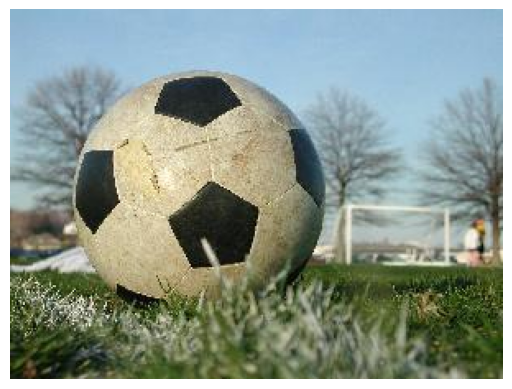

class ID: 84
class name: soccer_ball


In [12]:
image_path = "/kaggle/working/caltech101/101_ObjectCategories/soccer_ball/image_0012.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off') 
plt.show()
inference(image_path)